### Read the Data into dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as ss; ss.set()

# The G1 and G2 durations for control cells
df = pd.read_excel(r'C:\Users\farna\Desktop\emission\data.xlsx')
#print(df)

### Pre-processing and Visualization

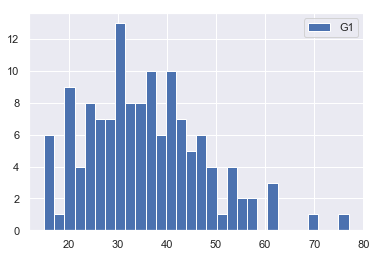

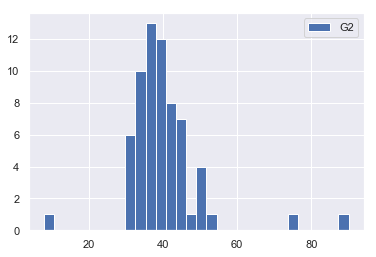

In [2]:
# dataframe into numpy array
a = df.values
G1 = a[:,0]
G2 = a[:,1]

# removing nan from the array
G2 = G2[~np.isnan(G2)]

# converting from unit of [frames] into [hours]
# every frame is every 30 minutes so we divide the numbers by 2 to have [hours]
G1_ = G1/2
G2_ = G2/2

# we need to normalize the data to be able to compare them with standard distributions
# Data points are now in interval [0, 1]
#G1 = (G1 - min(G1)) / (max(G1) - min(G1))
#G2 = (G2 - min(G2)) / (max(G2) - min(G2))


plt.hist(G1, bins = 30, label = 'G1')
plt.legend()
plt.show()

plt.hist(G2, bins = 30, label = 'G2')
plt.legend()
plt.show()

### To see if G1 and G2 are statistically independent:

### incomplete

In [3]:
from sklearn.feature_selection import mutual_info_regression

print(mutual_info_regression(G1.reshape(-1,1)[0:65],G2.reshape(-1,1)))

[0.04124785]


C:\Users\farna\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
import math
import operator
import warnings
warnings.filterwarnings('ignore')

### A list of candidate distributions with [0, inf] range:

distributions = ['betaprime', 'fatiguelife', 'chi', 'expon', 'f', 'foldnorm',
                 'frechet_r', 'frechet_l', 'gamma', 'erlang', 'invgamma', 'gompertz',
                'fisk', 'lognorm', 'loggamma', 'nakagami', 'pareto', 'rice', 'rayleigh',
                'dweibull']

#distributions = ['alpha', 'beta', 'dgamma', 'dweibull', 'expon', 'exponweib', 
#           'foldcauchy', 'foldnorm', 'gamma', 'gompertz', 'logistic', 
#           'lognorm', 'norm', 'rayleigh', 'anglit', 'arcsine', 'betaprime',
#           'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 
#           'fatiguelife', 'f', 'fisk', 'frechet_r', 'frechet_l', 'gausshyper',
#          'genpareto', 'genexpon', 'pareto', 'invgamma', 'halflogistic', 'hypsecant',
#          'laplace', 'loggamma', 'maxwell', 'nakagami', 'ncx2', 'nct', 'rdist',
#           'reciprocal', 'rice', 't', 'triang', 'truncexpon', 'truncnorm',
#          'ksone']

#######------Check the list of distributions and fit to the data --------#######

def check_dist(data, dist, verbose = False):
    '''
    The function to check the data against distributions.
    
    This function uses fit method in scipy package to find the maximum likelihood estimate
    distribution that fits the data, p-value is then obtained from ks-test, and returns
    the best distribution and its p-value.
    
    Args:
    -----------
    data (1D-array): the data we want to find the fit distribution for.
    dist (list of str): a list of strings that are pre-defined distributions in scipy package
    verbose (bool): if it is True, when we call the function it will print out every distribution 
    and its p-value that is evaluated.
    
    Returns:
    -----------
    best_dist (str): the best fit distribution found by ks-test
    p_val[best_dist] (float): the p-value corresponding to the best fit distribution 
    
    '''
    p_val = {}
    for i , val in enumerate(dist):
        parameters = eval('sp.'+val+'.fit(data, fscale =1)')
    
        D, p = sp.kstest(data, val, args = parameters)
    
        if math.isnan(D): D = 0
        if math.isnan(p): p = 0
            

        if verbose:
            print(dist[i], ':   ', 'p-value = ', p)
        p_val[val] = p
    
    best_dist = max(p_val, key = p_val.get)
    
    return(best_dist, p_val[best_dist])


betaprime :    p-value =  0.9496245807703753
fatiguelife :    p-value =  0.0
chi :    p-value =  0.0
expon :    p-value =  0.0
f :    p-value =  0.0
foldnorm :    p-value =  0.0
frechet_r :    p-value =  0.0
frechet_l :    p-value =  0.0
gamma :    p-value =  0.7730477413285115
erlang :    p-value =  0.7730478543522439
invgamma :    p-value =  0.0
gompertz :    p-value =  0.0
fisk :    p-value =  0.0
lognorm :    p-value =  0.0
loggamma :    p-value =  2.220446049250313e-16
nakagami :    p-value =  0.0
pareto :    p-value =  0.0
rice :    p-value =  0.0
rayleigh :    p-value =  0.0
dweibull :    p-value =  8.881784197001252e-16

 -----------------------------------------
 best distribution to estimate G1 is: 
 betaprime with p_value =  0.9496245807703753
params g1 (12.41238053679903, 50.00946709025631, -1.216101493210673, 145.11320270207517)


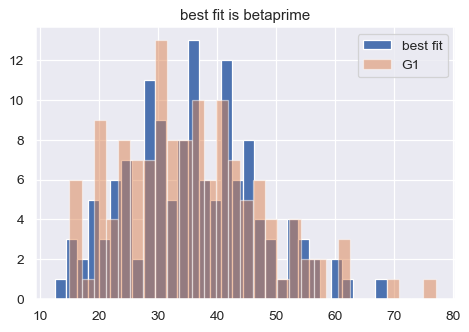

In [5]:
######-----------------------------G1-----------------------------########

G1_dist_est , G1_pval_est = check_dist(G1, distributions, verbose = True)
print('\n -----------------------------------------\n best distribution to estimate G1 is: \n',
      G1_dist_est, 'with p_value = ', G1_pval_est)


# this is the best fit
params_G1 = eval('sp.'+G1_dist_est+'.fit(G1)')
print('params g1', params_G1)

# want to plot the histogram of the best fit and data
y = eval('sp.'+G1_dist_est+'.rvs(params_G1[0], params_G1[1], params_G1[2], params_G1[3], size = len(G1), random_state = 0)')
#estimated_G2_dist = (x - min(x)) / (max(x) - min(x))


# plot histogram
plt.figure(dpi = 90)
plt.hist(y, bins = 30, label = 'best fit')
plt.hist(G1, bins = 30, alpha = 0.5, label = 'G1')
plt.title('best fit is {}'.format(G1_dist_est))
plt.legend()
plt.show()


betaprime :    p-value =  0.06029922688363665
fatiguelife :    p-value =  0.0
chi :    p-value =  1.5481615989187958e-11
expon :    p-value =  0.0
f :    p-value =  0.0
foldnorm :    p-value =  7.07144089950873e-08
frechet_r :    p-value =  0.0
frechet_l :    p-value =  0.0
gamma :    p-value =  0.04329344124461376
erlang :    p-value =  0.043293992146724136
invgamma :    p-value =  0.0
gompertz :    p-value =  0.0
fisk :    p-value =  0.0
lognorm :    p-value =  0.0
loggamma :    p-value =  0.0001415951932970394
nakagami :    p-value =  0.0
pareto :    p-value =  0.0
rice :    p-value =  0
rayleigh :    p-value =  0.0
dweibull :    p-value =  6.396234070105145e-05

 -----------------------------------------
 best distribution to estimate G2 is: 
 betaprime with p_value =  0.06029922688363665
params g2 (45.53151785098447, 1437.0990644341746, -22.97025918531139, 1985.8953005700723)


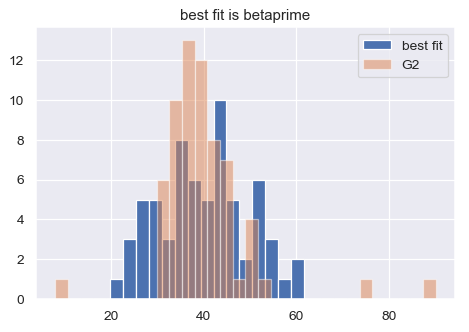

In [6]:
######-----------------------------G2-----------------------------########

G2_dist_est , G2_pval_est = check_dist(G2, distributions, verbose = True)
print('\n -----------------------------------------\n best distribution to estimate G2 is: \n',
      G2_dist_est, 'with p_value = ', G2_pval_est)


# this is the best fit
params_G2 = eval('sp.'+G2_dist_est+'.fit(G2)')
print('params g2', params_G2)

# want to plot the histogram of the best fit and data
x = eval('sp.'+G2_dist_est+'.rvs(params_G2[0], params_G2[1], params_G2[2], params_G2[3], size = len(G2), random_state = 0)')
#estimated_G2_dist = (x - min(x)) / (max(x) - min(x))


# plot histogram
plt.figure(dpi = 90)
plt.hist(x, bins = 15, label = 'best fit')
plt.hist(G2, bins = 30, alpha = 0.5, label = 'G2')
plt.title('best fit is {}'.format(G2_dist_est))
plt.legend()
plt.show()
